In [44]:
from tensorflow.keras.layers import Input, DepthwiseConv2D, \
     Conv2D, BatchNormalization, ReLU, AvgPool2D, Flatten, Dense, Concatenate,GlobalAvgPool2D, Add, Lambda, Activation, Reshape

import numpy as np

import math

from tensorflow.keras import Model

from keras.utils.np_utils import to_categorical
from keras import utils as np_utils
import food_mnist

import warnings
warnings.filterwarnings("ignore")

In [2]:
(x_train, y_train), (x_test, y_test) = food_mnist.load_data()
labels_names = food_mnist.labels()

In [3]:
x_train = x_train/255.
x_test = x_test/255.

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
print ("number of training examples = " + str(x_train.shape[0]))
print ("number of test examples = " + str(x_test.shape[0]))
print ("X_train shape: " + str(x_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_test shape: " + str(x_test.shape))
print ("Y_test shape: " + str(y_test.shape))
print(y_train[500])

number of training examples = 3750
number of test examples = 1250
X_train shape: (3750, 224, 224, 3)
Y_train shape: (3750, 10)
X_test shape: (1250, 224, 224, 3)
Y_test shape: (1250, 10)
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [38]:
def reshapes(x):
    y = Reshape((1,1,int(x.shape[1])))(x)
    return y

def softmaxs(x):
    y = softmax(x)
    return y

def slices(x,channel):
    y = x[:,:,:,:channel] 
    return y

def multiply(x,excitation):
    scale = x * excitation
    return scale

def squeezes(x):
    y = K.squeeze(x,1)
    return y

In [39]:
def SEModule(x,outchannels,ratio):
    x1 = GlobalAveragePooling2D(data_format='channels_last')(x)
    #squeeze = Reshape((1,1,int(x1.shape[1])))(x1)
    squeeze = Lambda(reshapes)(x1)
    fc1 = Conv2D(int(outchannels/ratio),(1,1),strides=(1,1),padding='same',data_format='channels_last',
                 use_bias=False,activation=None)(squeeze)
    relu= Activation('relu')(fc1)
    fc2 = Conv2D(int(outchannels),(1,1),strides=(1,1),padding='same',data_format='channels_last',
                 use_bias=False,activation=None)(relu)
    excitation = Activation('hard_sigmoid')(fc2)
    #scale = x * excitation
    scale = Lambda(multiply,arguments={'excitation':excitation})(x)
    return scale

In [40]:
def GhostModule(x,outchannels,ratio,convkernel,dwkernel,padding='same',strides=1,data_format='channels_last',
                use_bias=False,activation=None):
    conv_out_channel = math.ceil(outchannels*1.0/ratio)
    x = Conv2D(int(conv_out_channel),(convkernel,convkernel),strides=(strides,strides),padding=padding,data_format=data_format,
               activation=activation,use_bias=use_bias)(x)
    if(ratio==1):
        return x
    
    dw = DepthwiseConv2D(dwkernel,strides,padding=padding,depth_multiplier=ratio-1,data_format=data_format,
                         activation=activation,use_bias=use_bias)(x)
    #dw = dw[:,:,:,:int(outchannels-conv_out_channel)]
    dw = Lambda(slices,arguments={'channel':int(outchannels-conv_out_channel)})(dw)
    x = Concatenate(axis=-1)([x,dw])
    return x

In [41]:
def GhostBottleneck(x,dwkernel,strides,exp,out,ratio,use_se):
    x1 = DepthwiseConv2D(dwkernel,strides,padding='same',depth_multiplier=ratio-1,data_format='channels_last',
                         activation=None,use_bias=False)(x)
    x1 = BatchNormalization(axis=-1)(x1)
    x1 = Conv2D(out,(1,1),strides=(1,1),padding='same',data_format='channels_last',
               activation=None,use_bias=False)(x1)
    x1 = BatchNormalization(axis=-1)(x1)
    y = GhostModule(x,exp,ratio,1,3)
    y = BatchNormalization(axis=-1)(y)
    y = Activation('relu')(y)
    if(strides>1):
        y = DepthwiseConv2D(dwkernel,strides,padding='same',depth_multiplier=ratio-1,data_format='channels_last',
                         activation=None,use_bias=False)(y)
        y = BatchNormalization(axis=-1)(y)
        y = Activation('relu')(y)
    if(use_se==True):
        y = SEModule(y,exp,ratio)
    y = GhostModule(y,out,ratio,1,3)
    y = BatchNormalization(axis=-1)(y)
    y = Add()([x1,y])
    return y

In [42]:
INPUT_SHAPE = 224, 224, 3
input = Input(INPUT_SHAPE)

In [47]:
x = Conv2D(filters = 16, kernel_size= 3, strides=2, padding='same')(input)
x = BatchNormalization()(x)
x = ReLU()(x)

x = GhostBottleneck(x, dwkernel = 3, strides = 1, exp = 16, out = 16, ratio = 2, use_se = False)
x = GhostBottleneck(x, dwkernel = 3, strides = 2, exp = 48, out = 24, ratio = 2, use_se = False)
x = GhostBottleneck(x, dwkernel = 3, strides = 1, exp = 72, out = 24, ratio = 2, use_se = False)
x = GhostBottleneck(x, dwkernel = 5, strides = 2, exp = 72, out = 40, ratio = 2, use_se = False)
# x = GhostBottleneck(x,5,1,120,40,2,True)
# x = GhostBottleneck(x,3,2,240,80,2,False)
# x = GhostBottleneck(x,3,1,200,80,2,False)
# x = GhostBottleneck(x,3,1,184,80,2,False)
# x = GhostBottleneck(x,3,1,184,80,2,False)
# x = GhostBottleneck(x,3,1,480,112,2,True)
# x = GhostBottleneck(x,3,1,672,112,2,True)
# x = GhostBottleneck(x,5,2,672,160,2,True)
# x = GhostBottleneck(x,5,1,960,160,2,False)
# x = GhostBottleneck(x,5,1,960,160,2,True)
# x = GhostBottleneck(x,5,1,960,160,2,False)
# x = GhostBottleneck(x,5,1,960,160,2,True)  
# x = Conv2D(960,(1,1),strides=(1,1),padding='same',data_format='channels_last',activation=None,use_bias=False)(x)
x = GlobalAvgPool2D()(x)
# x = Lambda(reshapes)(x)
# x = Conv2D(1280,(1,1),strides=(1,1),padding='same',data_format='channels_last',activation=None,use_bias=False)(x)
x = Dense(100, activation="relu")(x)
output = Dense(units=10, activation='softmax')(x)

In [48]:
model=Model(inputs=input,outputs=output)
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 112, 112, 16) 448         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_121 (BatchN (None, 112, 112, 16) 64          conv2d_93[0][0]                  
__________________________________________________________________________________________________
re_lu_12 (ReLU)                 (None, 112, 112, 16) 0           batch_normalization_121[0][0]    
_______________________________________________________________________________________

In [49]:
history = model.fit(x_train, y_train, epochs=5)

Epoch 1/5
118/118 [==============================] - 146s 1s/step - loss: 2.0547 - accuracy: 0.2547
Epoch 2/5
118/118 [==============================] - 148s 1s/step - loss: 1.8360 - accuracy: 0.3611
Epoch 3/5
118/118 [==============================] - 145s 1s/step - loss: 1.7042 - accuracy: 0.3840
Epoch 4/5
118/118 [==============================] - 145s 1s/step - loss: 1.6375 - accuracy: 0.4176
Epoch 5/5
118/118 [==============================] - 154s 1s/step - loss: 1.5686 - accuracy: 0.4339


In [50]:
ypred = model.predict(x_test)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(y_test[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data:', total, '\nAccurately-predicted-data:', accurate)
print('Wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data: 1250 
Accurately-predicted-data: 461
Wrongly-predicted-data:  789
Accuracy: 36.88 %


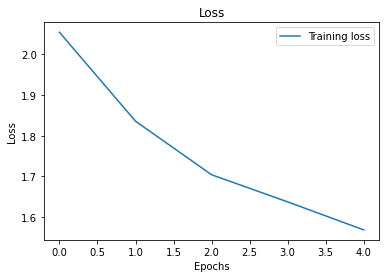

In [51]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = np.arange(0,5)
plt.plot(epochs, loss, label='Training loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

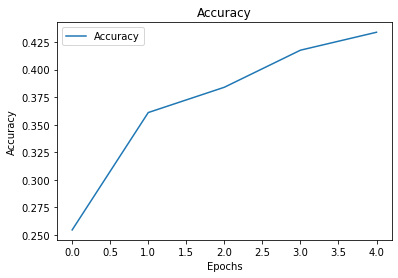

In [52]:
accuracy = history.history['accuracy']
epochs = np.arange(0,5)
plt.plot(epochs, accuracy, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()